In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [110]:
df = pd.read_csv("merged_data.csv")

In [111]:
df.head()

,name,id,type,classification,mass,fall,year,latitude,longitude,country,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Haven,11858,Valid,H6,6100.0,Found,1950.0,37.96417,-97.75583,United States,...,25.239417,25.479003,25.713686,25.939171,26.155144,26.323940,26.445826,26.590781,26.769253,26.948271
1,St. Louis,23089,Valid,H4,1000.0,Fell,1950.0,38.70000,-90.23333,United States,...,25.239417,25.479003,25.713686,25.939171,26.155144,26.323940,26.445826,26.590781,26.769253,26.948271
2,Arroyo Aguiar,2340,Valid,H5,7450.0,Fell,1950.0,-31.41667,-60.66667,Argentina,...,15.573055,15.724678,15.863864,15.994957,16.109071,16.187335,16.230432,16.264683,16.311426,16.367933
3,Plainview (1950),18842,Valid,H,2200.0,Found,1950.0,34.11667,-101.78333,United States,...,25.239417,25.479003,25.713686,25.939171,26.155144,26.323940,26.445826,26.590781,26.769253,26.948271
4,Santa Rosalia,23168,Valid,"Pallasite, PMG",1631.0,Found,1950.0,27.33333,-112.33333,Mexico,...,61.795294,62.397078,62.983378,63.582411,64.189415,64.718226,65.151603,65.644123,66.219161,66.791446


In [112]:
# Drop rows with missing values
df = df.dropna()

In [113]:
# Create a subset of the population density DataFrame for 2015
population_density = df[['country', '2015']].copy()

In [114]:
df = df[df["fall"] == "Fell"].drop(columns=["fall"])
df= df.drop(columns=["name", "id", "type", "classification", "country"])

In [115]:
features = df.columns.difference(["latitude", "longitude"])
target = ["latitude", "longitude"]

In [116]:
print(df.columns)

Index(['mass', 'year', 'latitude', 'longitude', '1950', '1951', '1952', '1953',
       '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962',
       '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'],
      dtype='object')


In [117]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [118]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [119]:
# Train separate models for Latitude and Longitude
lat_model = RandomForestRegressor(n_estimators=100, random_state=42)
lon_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [120]:
# Train models
lat_model.fit(X_train_scaled, y_train["latitude"])
lon_model.fit(X_train_scaled, y_train["longitude"])

RandomForestRegressor(random_state=42)

In [121]:
# Make predictions
lat_pred = lat_model.predict(X_test_scaled)

In [122]:
lon_pred = lon_model.predict(X_test_scaled)

In [123]:
from haversine import haversine, Unit

In [124]:
def haversine_error(y_true, y_pred):
    total_distance = 0
    for i in range(len(y_true)):
        true_point = (y_true.iloc[i]["latitude"], y_true.iloc[i]["longitude"])
        pred_point = (y_pred[i][0], y_pred[i][1])
        total_distance += haversine(true_point, pred_point, unit=Unit.KILOMETERS)
    return total_distance / len(y_true)  # Average error in km

In [125]:
# Compute error
y_pred = np.column_stack((lat_pred, lon_pred))
error_km = haversine_error(y_test, y_pred)

In [126]:
print(f"Average Haversine Error: {error_km:.2f} km")

Average Haversine Error: 1921.83 km


In [127]:
# Scale input
future_scaled = scaler.transform(X_test)

# Predict future meteorite location
future_lat = lat_model.predict(future_scaled)
future_lon = lon_model.predict(future_scaled)

print(f"Predicted Meteorite Location: Latitude {future_lat[0]:.4f}, Longitude {future_lon[0]:.4f}")

Predicted Meteorite Location: Latitude 35.8939, Longitude 113.3540


In [128]:
import matplotlib.pyplot as plt
import geopandas as gpd

In [129]:
# Load the world shapefile using your custom path
world_shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
world = gpd.read_file(world_shapefile_path)

In [130]:
pred_df = pd.DataFrame({"latitude": lat_pred, "longitude": lon_pred})
gdf_predicted = gpd.GeoDataFrame(pred_df, geometry=gpd.points_from_xy(pred_df.longitude, pred_df.latitude))

In [131]:
y_test

,latitude,longitude
1961,32.33333,114.31667
35207,38.70066,-77.21163
29922,59.43333,10.70000
14551,-7.03333,-40.16667
1805,44.05000,126.16667
...,...,...
411,45.30000,0.23333
5780,17.90000,101.63333
5750,64.02000,161.80833
7063,11.49167,11.65833


In [132]:

# Convert true values into a GeoDataFrame
gdf_actual = gpd.GeoDataFrame(y_test, geometry=gpd.points_from_xy(y_test["longitude"], y_test["latitude"]))

In [133]:
world.rename(columns={'ADMIN': 'name'}, inplace=True) 

In [134]:
# Names of some of the countries are not the same in the map and the population data so they need to be remapped first
name_mapping = {
    "Russian Federation": "Russia",
    "Bolivia (Plurinational State of)": "Bolivia",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Bahamas": "The Bahamas",
    "Côte d'Ivoire": "Ivory Coast",
    "Dem. Rep. of the Congo": "Democratic Republic of the Congo",
    "Republic of Moldova": "Moldova",
    "Republic of Korea": "South Korea",
    "Serbia": "Republic of Serbia",
    "Congo": "Republic of the Congo",
    "Viet Nam": "Vietnam",
    "China, Taiwan Province of China": "Taiwan",
    "Dem. People's Rep. of Korea": "North Korea",
    "Brunei Darussalam": "Brunei",
    "State of Palestine": "Palestine",
    "Falkland Islands (Malvinas)": "Falkland Islands",
    "Lao People's Dem. Republic": "Laos",
    "Timor-Leste": "East Timor",
    "Kosovo (under UNSC res. 1244)": "Kosovo",
    "Eswatini": "eSwatini",
    "Syrian Arab Republic": "Syria",
    "Iran (Islamic Republic of)": "Iran",
    "Türkiye": "Turkey"
}

In [136]:
population_density

,country,population_density
0,United States,25.239417
1,United States,25.239417
2,Argentina,15.573055
3,United States,25.239417
4,Mexico,61.795294
...,...,...
36225,United States,25.239417
36257,United States,25.239417
36368,Chile,23.969094
36410,United States,25.239417


In [137]:
# Rename columns for consistency
population_density.rename(columns={'country': 'name', '2015': 'population_density'}, inplace=True)
population_density['name'] = population_density['name'].replace(name_mapping)
# Merge with the world GeoDataFrame
world_merged = world.merge(population_density, on='name', how='left')

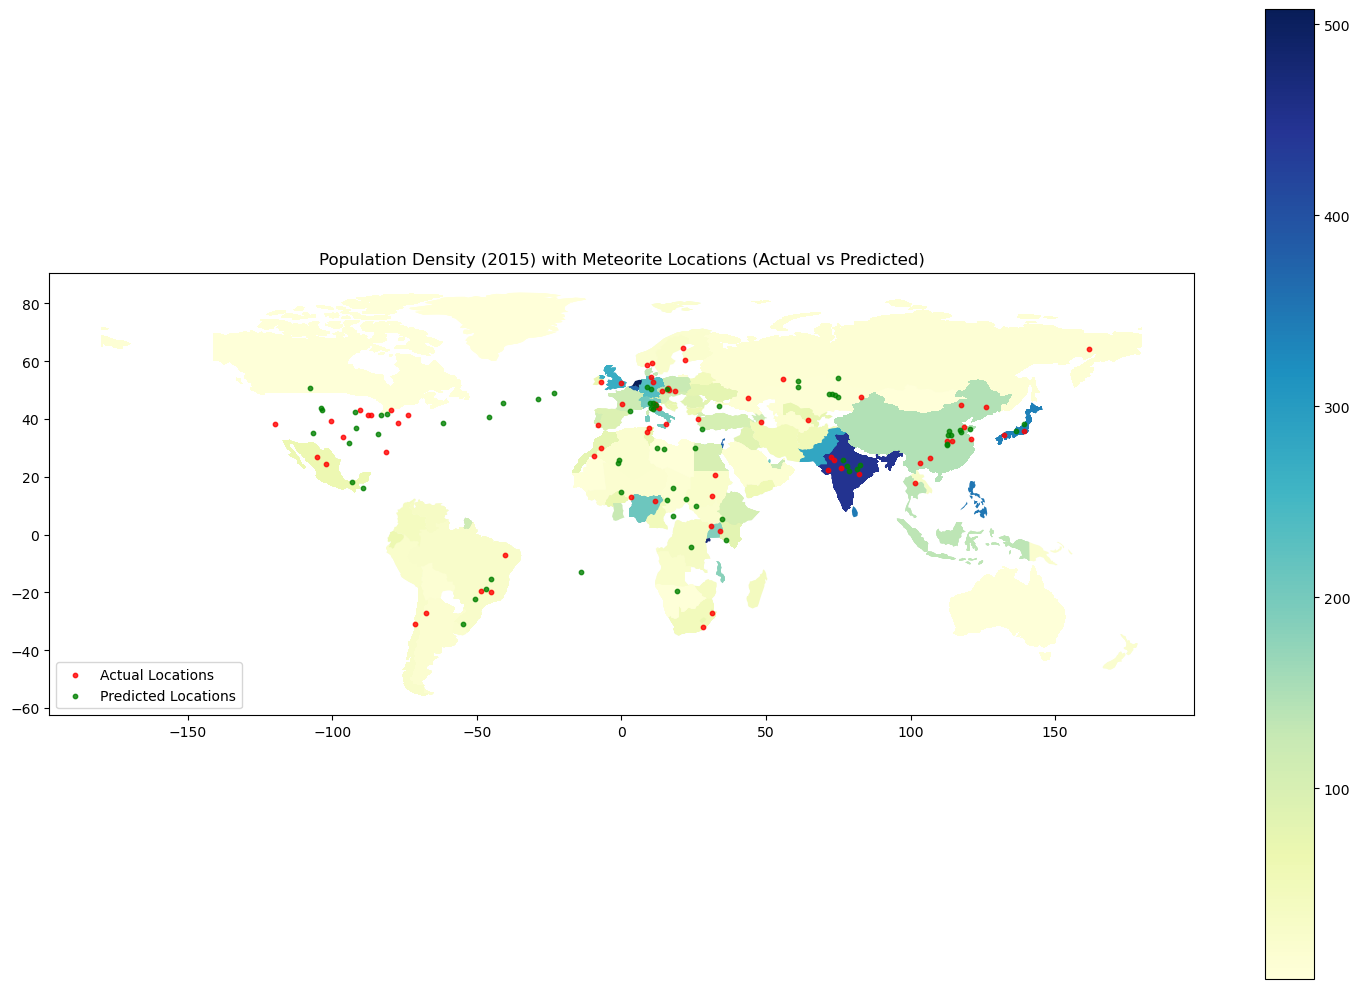

In [138]:
# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the population density heatmap
world_merged.plot(column='population_density', cmap='YlGnBu', legend=True, ax=ax)

# Plot actual meteorite falls (red)
gdf_actual.plot(ax=ax, color='red', markersize=10, alpha=0.8, label="Actual Locations")

# Plot predicted meteorite falls (green)
gdf_predicted.plot(ax=ax, color='green', markersize=10, alpha=0.8, label="Predicted Locations")

# Add title and legend
ax.set_title("Population Density (2015) with Meteorite Locations (Actual vs Predicted)")
ax.legend(loc="lower left")

# Show the plot
plt.tight_layout()
plt.show()